# Poor Confidence Analysis
This analysis aims to improve the NER model by studying the predictions done by the model. This is done firstly by identifying the weakness or limitations discovered from the prediction results. So, by looking at the outputs, the confidence score can be the area of focus for this analysis.

The idea of this analysis is to find out if the low confidence scores are justifiable. For example, is the confidence score related to the volume of the dataset, frequency of the labels, or word rarity?

This can be determined by answering these questions:
1. Is there a correlation between label frequency and confidence scores?    (`label`)
2. Are low-confidence predictions associated with text frequency/rarity?    (`text`)
3. Do certain entity types show systematic confidence patterns?             (`label`)
4. Is confidence score correlated with word length or complexity?           (`text`)
5. Does context window size affect confidence?

Based on these questions, 

* If low scores correlate with rare labels: Augment training data for underrepresented classes
* If low scores correlate with rare words: Add domain-specific vocabulary for training 
* If low scores are consistent with certain label group: Review annotation
* If low scores are consistent with longer words/phrase: Review span detection
* If low scores cluster in specific positions: Review context window

If all are unclear: Review model architecture or hyperparameter tuning

-------------
------
## Data Preparation

#### Import Libraries

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats             # correlation

#### Load Dataset

In [204]:
# load csv
df = pd.read_csv('results_main.csv')
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [205]:
df.info

<bound method DataFrame.info of         start     end                 text    label     score
0           0      13        operasi kesan    EVENT  0.630561
1          36      42               ec120b  PRODUCT  0.817231
2          62      67                ipcmc      ORG  0.962938
3         110     125      utusan malaysia      ORG  0.784653
4         170     180           ezad lazim   PERSON  0.918969
...       ...     ...                  ...      ...       ...
13980  826810  826816               negara      LOC  0.810654
13981  826818  826829          johor bahru      LOC  0.759652
13982  826916  826925            singapura      LOC  0.734750
13983  826961  826980  minyak petrol ron95  PRODUCT  0.777760
13984  827018  827023                johor      LOC  0.838383

[13985 rows x 5 columns]>

In [206]:
# normalize text
df['text'] = df['text'].str.lower()
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [207]:
# duplicates
df.drop_duplicates().head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


-------------
--------
## Exploratory Data Analysis
This part aims to explore the dataset in hopes to uncover hidden perspectives.

#### Label Distribution

In [208]:
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [209]:
# label distribution
df['label'].value_counts()

label
ORG            3389
PERSON         3173
LOC            3026
EVENT           894
GPE             743
PRODUCT         688
TIME            629
MONEY           429
QUANTITY        315
LAW             283
WORK_OF_ART     153
PERCENT         130
CARDINAL         66
NORP             43
FAC              22
ORDINAL           2
Name: count, dtype: int64

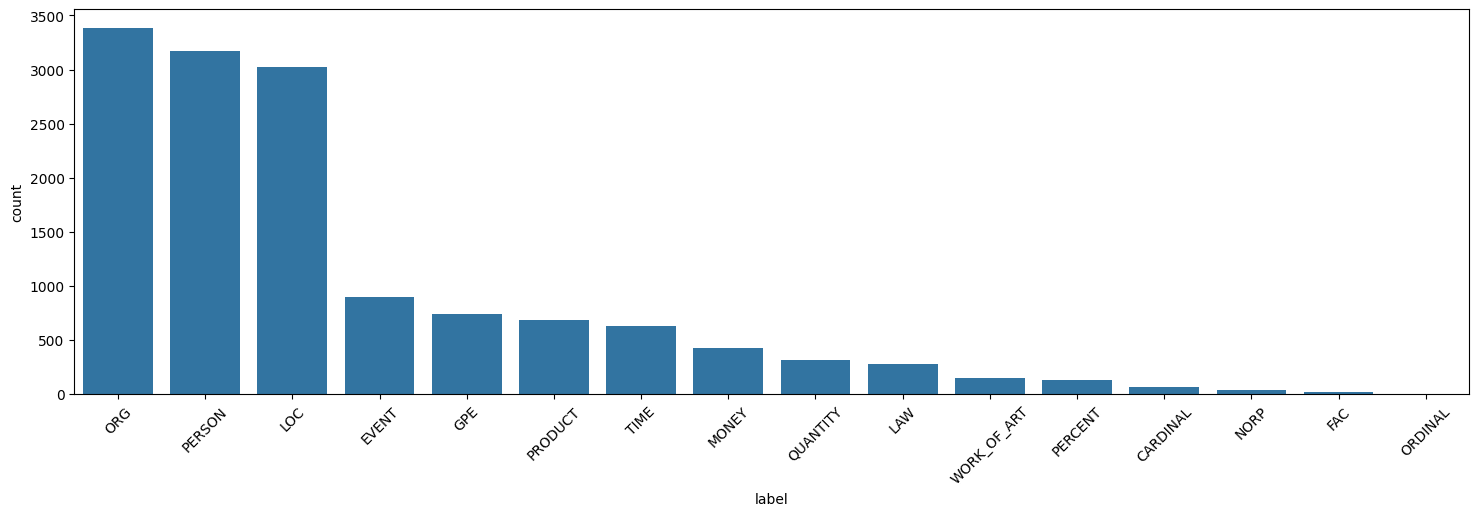

In [210]:
# visualize
label_freq = df['label'].value_counts().index

plt.figure(figsize=(18,5))
sns.countplot(x=df['label'],data=df, order=label_freq)
plt.xticks(rotation=45)
plt.show()

From this graph, it is safe to assume that the high-frequency labels are the 3 highest, while the others are teh low-frequency labels. This is because the gap between the third and the fourth highest is relatively big (1500 vs 500), when compared to other inter-label gaps.

#### High and Low Frequency Labels

In [211]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [212]:
# drop columns
freq = df.drop(['start','end','text'], axis=1)
freq.head()

,label,score
0,EVENT,0.630561
1,PRODUCT,0.817231
2,ORG,0.962938
3,ORG,0.784653
4,PERSON,0.918969


In [213]:
# list labels
freq['label'].unique()

array(['EVENT', 'PRODUCT', 'ORG', 'PERSON', 'QUANTITY', 'GPE', 'LOC',
       'TIME', 'MONEY', 'LAW', 'CARDINAL', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL'], dtype=object)

In [214]:
# split into higher and lower frequency groups
high_label = ['PERSON','ORG','LOC']
low_label = ['PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL']

freq_high = freq[freq['label'].isin(high_label)]
freq_low = freq[freq['label'].isin(low_label)]

#### Confidence Scores in High and Low Frequency Labels

In [215]:
# get mean score
label_score_mean_high = freq_high.groupby('label')['score'].mean().reset_index()
label_score_mean_low = freq_low.groupby('label')['score'].mean().reset_index()

In [216]:
# sort mean score
label_score_mean_high = label_score_mean_high.sort_values('score', ascending=False)
label_score_mean_low = label_score_mean_low.sort_values('score', ascending=False)

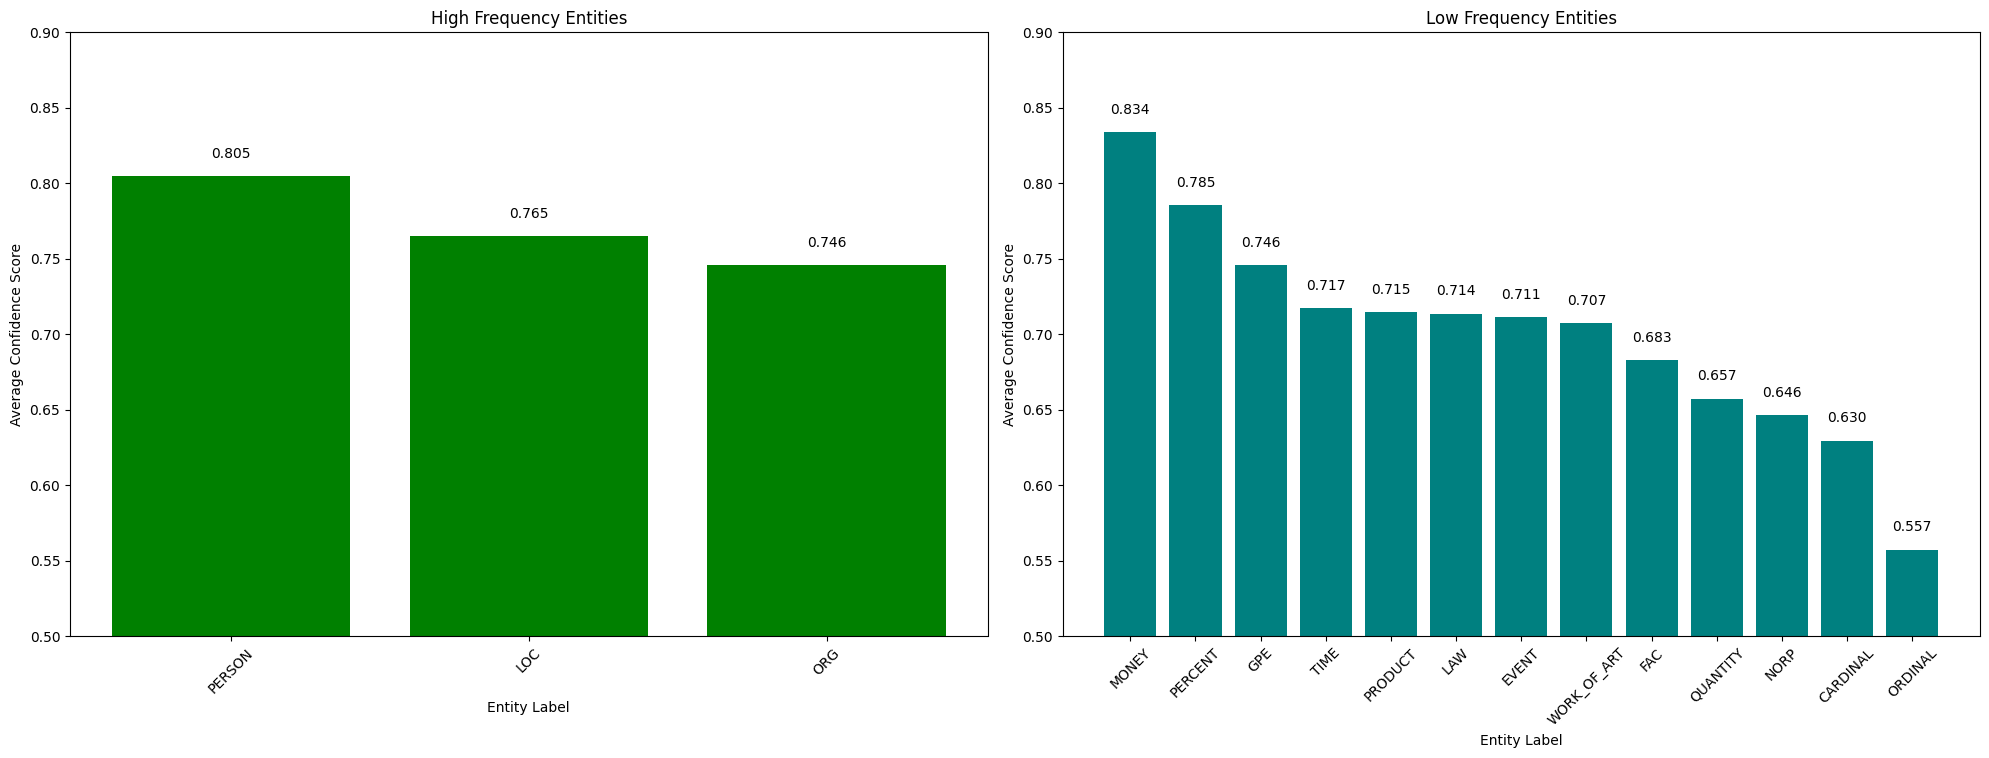

In [217]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# high frequency labels
bars1 = ax1.bar(label_score_mean_high['label'], 
               label_score_mean_high['score'],
               color='green')

# labeling
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax1.set_title('High Frequency Entities')
ax1.set_xlabel('Entity Label')
ax1.set_ylabel('Average Confidence Score')
ax1.set_ylim(0.5, 0.9)
ax1.tick_params(axis='x', rotation=45)

# low frequency labels
bars2 = ax2.bar(label_score_mean_low['label'], 
               label_score_mean_low['score'],
               color='teal')

# labeling
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax2.set_title('Low Frequency Entities')
ax2.set_xlabel('Entity Label')
ax2.set_ylabel('Average Confidence Score')
ax2.set_ylim(0.5, 0.9)
ax2.tick_params(axis='x', rotation=45)

# display
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
plt.show()

Based on these graphs, the lowest confidence score for the high-frequency labels is around 76%, while the highest confidence score for the low-frequency labels is around 82%. This means that even if the label is relatively rare, the confidence score can still be high. Even so, it cannot be a certain that there is no correlation between the label rarity and the confidence score. Therefore, a correlation analysis can be done to further confirm this.

#### Low Rarity Texts

In [244]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [245]:
# text frequency
text_freq = df['text'].value_counts().reset_index() 
text_freq

,text,count
0,utusan malaysia,349
1,kuala lumpur,239
2,malaysia,221
3,polis,115
4,petaling jaya,90
...,...,...
6221,rm30,1
6222,baka sultan,1
6223,hasmah hashim,1
6224,xo bukit,1


In [246]:
# texts that appeared only once
text_low = text_freq[text_freq['count'] == 1]
text_low

,text,count
2033,pikap,1
2034,26 tahun,1
2035,aktasakithati,1
2036,van,1
2037,dr. ismuni bohari,1
...,...,...
6221,rm30,1
6222,baka sultan,1
6223,hasmah hashim,1
6224,xo bukit,1


From this, there are about 4000 texts that appeared only once. That's more than half of the whole dataset (6000 texts)! This is also while excluding the texts that appeared only twice or thrice.

However, this is to be expected since texts with unique nomenclature or numbers might be a factor to this phenomenon. 

#### Distribution of Confidence Score in Low Rarity Texts

In [251]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [258]:
# get score for low rarity texts
text_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

text_low_conf = pd.merge(text_freq, text_conf, on='text')
text_low_conf = text_low_conf[text_low_conf['count'] == 1]
text_low_conf.sort_values('score',ascending=False)

,text,count,score
2117,harvey elliott,1,0.995564
3583,novak djokovic,1,0.995105
2718,harry maguire,1,0.994720
3504,mimi fly,1,0.994010
2702,muhammad yunus,1,0.993510
...,...,...,...
5168,"33,049",1,0.500541
4519,lengkapkan,1,0.500489
5445,calon mentua,1,0.500295
4576,bekalan makanan,1,0.500189


Here, we can see that the rare texts has the confidence score at both high and low ends.

--------------
--------------
## Data Analysis

-------------
### Q1: Is there a correlation between label frequency and confidence scores?
Study on the mean confidence scores and label frequency correlation. This is to see if high frequency means high confidence score, or vice versa.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [222]:
# create new dataset
q1_label = df['label'].value_counts().reset_index()         # get label frequency
q1_conf = df.groupby('label')['score'].mean().reset_index() # get mean confidence score

label_analysis = pd.merge(q1_label, q1_conf, on='label')
label_analysis.sort_values('score',ascending=False)

,label,count,score
7,MONEY,429,0.834056
1,PERSON,3173,0.804897
11,PERCENT,130,0.785446
2,LOC,3026,0.765021
0,ORG,3389,0.745839
4,GPE,743,0.745806
6,TIME,629,0.717365
5,PRODUCT,688,0.714888
9,LAW,283,0.713684
3,EVENT,894,0.711486


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship
3. Shapiro-Wilk test - to determine if its normally distributed

**Null hypothesis:**\
There is no correlation between label frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between label frequency and confidence scores.

In [ ]:
# pearson
pearson_corr, p_value = stats.pearsonr(
    label_analysis['frequency'],
    label_analysis['avg_confidence']
)

# spearman
spearman_rho, p_spearman = stats.spearmanr(
    label_analysis['frequency'],
    label_analysis['avg_confidence']
)

# normality test
shapiro_test = stats.shapiro(label_analysis['avg_confidence'])

In [ ]:
print(f"Spearman rho: {spearman_rho:.3f}")
print(f"Spearman p: {p_spearman:.4f}\n")
print(f"Pearson r: {pearson_corr:.3f}")
print(f"Pearson p: {p_value:.4f}\n")
print(f"Shapiro-Wilk W:{shapiro_test[0]:.3f}")
print(f"Shapiro-Wilk p: {shapiro_test[1]:.4f}\n")

Spearman rho: 0.679
Spearman p: 0.0038

Pearson r: 0.493
Pearson p: 0.0525

Shapiro-Wilk W:0.977
Shapiro-Wilk p: 0.9369



Based on these results:
* There is a significant (p < 0.05) strong positive monotonic relationship (rho > 0.6). This means that as label frequency increases, confidence scores consistently increase, but not necessarily in a straight-line pattern - Spearman correlation test
* There is a significant (p < 0.05) moderate positive linear relationship (r > 0.4, r < 0.6). This means that higher frequency moderately predicts higher confidence in a linear pattern. - Pearson correlation test
* Since the rho > r, the monotonic relationship is stronger than the linear relationship. This means that even though higher frequency boosts the confidence score, the boost will decrease with higher frequency.
* Since both of these tests are significant, the results are not random.
* The data is normally distributed (p > 0.05). - Shapiro-Wilk test

Therefore, we reject the null hypothesis.

For fine-tuning, training data that focuses on the low-frequency labels can be used for augmentation.

In [ ]:
# filter low-frequency labels in main dataset
q1_low_full = df[df['label'].isin(low_label)]
q1_low_full.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
12,338,340,31,QUANTITY,0.931890
13,377,385,malaysia,GPE,0.832705
16,425,434,kejuaraan,EVENT,0.646641


------------
### Q2: Are low-confidence predictions correlated with text frequency/rarity?
Study on the low confidence scores and text frequency. This is to see if lower rarity means lower confidence score, or vice versa.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [224]:
# create new dataset
q2_text = df['text'].value_counts().reset_index()           # get text frequency
q2_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

text_analysis = pd.merge(q2_text, q2_conf, on='text')
text_analysis

,text,count,score
0,utusan malaysia,349,0.713765
1,kuala lumpur,239,0.867927
2,malaysia,221,0.742725
3,polis,115,0.766424
4,petaling jaya,90,0.737853
...,...,...,...
6221,rm30,1,0.530657
6222,baka sultan,1,0.543795
6223,hasmah hashim,1,0.953985
6224,xo bukit,1,0.547932


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text frequency and confidence scores.

In [ ]:
# pearson
pearson_corr, p_value = stats.pearsonr(
    text_analysis['frequency'],
    text_analysis['avg_confidence']
)

# spearman
spearman_rho, p_spearman = stats.spearmanr(
    text_analysis['frequency'],
    text_analysis['avg_confidence']
)

In [ ]:
print(f"Spearman rho: {spearman_rho:.3f}")
print(f"Spearman p: {p_spearman:.4f}\n")
print(f"Pearson r: {pearson_corr:.3f}")
print(f"Pearson p: {p_value:.4f}\n")

Spearman rho: 0.034
Spearman p: 0.0079

Pearson r: 0.012
Pearson p: 0.3495



Based on these results:
* There is a significant (p < 0.05) but negligible monotonic relationship (rho < 0.1). This means that there is no meaningful relationship between text and confidence score. - Spearman correlation test
* There is no significant (p > 0.05) linear relationship (r < 0.1). This means that there is no evidence of linear relationship between text and confidence score. - Pearson correlation test

Therefore, we do not reject the null hypothesis.

The fine-tuning should be aimed at other factors instead.

This further justifies the EDA,  where the confidence scores are covered from both high and low ends from the texts, despite the rarity of the texts.

------------
### Q3: Do certain entity types show systematic confidence patterns?
Analyze score distributions per label type.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [ ]:
# get mean score for every label
q3 = df.groupby('label')['score'].mean().reset_index()
q3.columns = ['label', 'avg_confidence']

# sort
q3 = q3.sort_values('avg_confidence', ascending=False)
q3

,label,avg_confidence
6,MONEY,0.834056
11,PERSON,0.804897
10,PERCENT,0.785446
5,LOC,0.765021
9,ORG,0.745839
3,GPE,0.745806
14,TIME,0.717365
12,PRODUCT,0.714888
4,LAW,0.713684
1,EVENT,0.711486


In [ ]:
# filter only under 0.7
q3 = q3[q3['avg_confidence'] < 0.7]
q3

,label,avg_confidence
2,FAC,0.682768
13,QUANTITY,0.657402
7,NORP,0.646193
0,CARDINAL,0.629560
8,ORDINAL,0.557388


### Q4: Is confidence score correlated with word length or complexity?
Compute correlation between entity string length/number of tokens and confidence scores.

### Q5: Does context window size affect confidence?
Examine scores relative to entity position in sentence (beginning, middle, end).